In [5]:
import streamlit as st
import sqlite3
import os
import re
import datetime
import random
import pandas as pd

# Import necessary components from your workflow code
from langchain_openai import AzureChatOpenAI, AzureOpenAIEmbeddings
from pydantic import BaseModel, Field
from langchain_core.prompts import MessagesPlaceholder, ChatPromptTemplate
from langchain.agents import AgentExecutor
from langchain.tools import tool
from langchain.memory import ConversationBufferMemory
from langchain.output_parsers import PydanticOutputParser
from langchain.prompts import (
    SystemMessagePromptTemplate,
    HumanMessagePromptTemplate,
    ChatPromptTemplate
)
import seaborn as sns
import matplotlib.pyplot as plt
import io
# Import your custom prompts (ensure your prompts.py is in the same directory)
from prompts import *
import warnings
warnings.filterwarnings("ignore", message="FigureCanvasAgg is non-interactive")
warnings.filterwarnings("ignore", category=FutureWarning)


# --- Configuration for Azure OpenAI ---
OPENAI_DEPLOYMENT_ENDPOINT = "https://az-openai-document-question-answer-service.openai.azure.com/" 
OPENAI_API_KEY = "5d24331966b648738e5003caad552df8" 
OPENAI_API_VERSION = "2023-05-15"
OPENAI_DEPLOYMENT_NAME = "az-gpt_35_model"
OPENAI_MODEL_NAME="gpt-3.5-turbo"
OPENAI_ADA_EMBEDDING_DEPLOYMENT_NAME = "az-embedding_model" 
OPENAI_ADA_EMBEDDING_MODEL_NAME = "text-embedding-ada-002"
encoding_name = "cl100k_base"

# Initialize LLM and embedding model
llm = AzureChatOpenAI(
    temperature=0.1,
    deployment_name=OPENAI_DEPLOYMENT_NAME,
    model_name=OPENAI_MODEL_NAME,
    azure_endpoint=OPENAI_DEPLOYMENT_ENDPOINT,
    openai_api_version=OPENAI_API_VERSION,
    openai_api_key=OPENAI_API_KEY            
)
embedding_model = AzureOpenAIEmbeddings(
    openai_api_key=OPENAI_API_KEY,
    deployment=OPENAI_ADA_EMBEDDING_DEPLOYMENT_NAME,
    model=OPENAI_ADA_EMBEDDING_MODEL_NAME,
    azure_endpoint=OPENAI_DEPLOYMENT_ENDPOINT
)

# --- Define Data Models and Workflow Nodes (as in your notebook code) ---
from typing import TypedDict, List, Dict, Any
from langgraph.graph import StateGraph, START, END

class GraphState(TypedDict):
    user_query: str                 
    domain_confidences: List[Dict[str, Any]]  
    domains: List[str]              
    intent: str                     
    intent_confidence: float        
    tables: List[str]               
    metadata: Dict[str, str]        
    retrieved_docs: List[Any]       
    sql_queries: List[str]          
    verification: str               
    query_history: List[str]        
    error_history: List[str]        
    sql_result_str: str             
    nl_response: str                
    visualization_response: str
    report_response: str
    chat_history: List[str]         
    report: bool                    
    visualize: bool
    visual_instructions: str
    sql_result_df_list: List[Any]   
    goals: List[str]
    csv_files: Dict[str, bytes]      # For in-memory CSV report data.
    visualization_files: List[bytes] # For in-memory visualization PNG data.
    anomaly: bool                   # True if the user explicitly requests anomaly detection
    anomaly_detection: str          # Output from anomaly detection (explanation of outliers)
    final_output: Any 

# Define IntentModel and parser
class IntentModel(BaseModel):
    """Represents the user's query intent."""
    intent: str = Field(
        description="A short string describing the user's intent, breaking down complex queries into simpler parts."
    )
    confidence: float = Field(
        description="A float between 0 and 1 indicating how confident the system is about the intent."
    )
    report: bool = Field(
        description="True if the user explicitly requests a report; otherwise, false."
    )
    visualize: bool = Field(
        description="True if the user explicitly requests a visualization; otherwise, false."
    )
    visual_instructions: str = Field(
        default="",
        description="Any specific instructions provided by the user for the visualization."
    )
    anomaly: bool = Field(
        description="True if the user explicitly requests anomaly detection (e.g., 'detect anomalies', 'find outliers', 'identify unusual trends'); otherwise, false."
    )

structured_llm_intent = llm.with_structured_output(schema=IntentModel, method='function_calling')

system = """\
You are an assistant that identifies the user's intent from a query. The Intent will be used to create SQL query to query tables. So Generate the Intent in a way which will be helpful in future chains , SQL query 
generation and Table identification. Break down complex user query into simpler queries if necessary.
Expand Abbreviation wherever possible.
Return a JSON object with the following fields:
- 'intent': a string describing the user's overall intent only for the SQL query to be generated.
- 'confidence': a float between 0 and 1 indicating how certain you are about the intent.
- 'report': a boolean that is true ONLY if the user explicitly requests a report (for example, if the query includes phrases like 'generate a report', 'export', or 'create a report'); otherwise, false.
- 'visualize': a boolean that is true ONLY if the user explicitly requests a visualization (for example, if the query includes phrases like 'visualize', 'graph', 'chart', or 'plot'); otherwise, false.
- 'visual_instructions': a string containing any specific instructions provided by the user for visualization; if none are provided, return an empty string.
- 'anomaly': a boolean that is true ONLY if the user explicitly requests anomaly detection (for example, if the query includes phrases like 'detect anomalies', 'find outliers', or 'identify unusual trends'); otherwise, false.
"""
intent_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "User query: {user_query}"),
    ]
)

# Combine the prompt with the structured output LLM
intent_detector = intent_prompt | structured_llm_intent

# 4. Sample usage
def identify_intent(user_query: str) -> IntentModel:
    """
    Classifies the user's query into an IntentModel (intent + confidence).
    """
    # Pass variables to the prompt via invoke
    result = intent_detector.invoke({"user_query": user_query})
    return result  # This is an IntentModel instance

def intent_identification_node(state: GraphState) -> GraphState:
    # st.write("Running intent identification...")
    intent_result = identify_intent(state["user_query"])
    state["intent"] = intent_result.intent
    state["intent_confidence"] = intent_result.confidence
    state["report"] = intent_result.report
    state["visualize"] = intent_result.visualize
    state["visual_instructions"] = intent_result.visual_instructions
    state["anomaly"] = intent_result.anomaly
    return state



# SQL Generation Node (simplified version)

sql_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", sql_gen_system),
        ("system", census_domain_instructions),
        ("system", census_sample_sql_queries),
        ("system", census_table_metadata),
        ("system", census_entity_relationships),
        (
            "human",
            """\
Previous Queries Tried:
{query_history}

Errors Encountered:
{error_history}

User query: {user_query}
Intent: {intent}
"""
        ),
    ]
)

def sql_generation_node(state: dict) -> dict:
    # st.write("Generating SQL query...")
    query_history_str = "\n".join(state.get("query_history", [])) or "None"
    error_history_str = "\n".join(state.get("error_history", [])) or "None"
    prompt_value = sql_prompt.format_prompt(
        user_query=state.get('user_query', ""),
        intent=state.get('intent', ""),
        query_history=query_history_str,
        error_history=error_history_str
    )
    result = llm.invoke(prompt_value)
    raw_query = result.content.strip().strip("```").strip()
    queries = re.split(r';\s*(?=SELECT)', raw_query, flags=re.IGNORECASE)
    queries = [q.strip() for q in queries if q.strip()]
    queries = [q if q.endswith(';') else q + ';' for q in queries]
    state["sql_queries"] = queries
     # Update query history
    if "query_history" not in state:
        state["query_history"] = []
    state["query_history"].extend(queries)
    return state

# For executing SQL queries, assume we have a function to execute against your SQLite DB.
def execute_query_node(state: dict) -> dict:
    # st.write("Executing SQL queries...")
    sql_queries = state.get("sql_queries", [])
    db_filename = "census.db"
    if not sql_queries:
        error_msg = "No SQL queries found."
        state["sql_result_str"] = error_msg
        state.setdefault("error_history", []).append(error_msg)
        state["execution_error"] = True
        return state
    # conn = sqlite3.connect(db_filename)
    # # Debug: list available tables in the database
        # cursor = conn.cursor()
    # cursor.execute("SELECT name FROM sqlite_master WHERE type='table'")
    # tables = cursor.fetchall()
    # print("Available tables in DB:", tables)
    # state["available_tables"] = tables  # Save the list for debugging if needed
    result_str_list = []
    df_list = []
    execution_error = False
    # For demonstration, we execute against our local SQLite DB (census.db)
    # db_filename = "census.db"
    print(sql_queries)
    conn = sqlite3.connect(db_filename)
    for i, query in enumerate(sql_queries):
        try:
            df = pd.read_sql_query(query, conn)
            df_list.append(df)
            if df.empty:
                result_str = f"Query {i+1}: No rows returned."
            else:
                result_str = f"Query {i+1}:\n" + df.to_markdown()
            result_str_list.append(result_str)
        except Exception as e:
            error_msg = f"Error executing Query {i+1}:\n{query}\nException: {e}"
            result_str_list.append(error_msg)
            execution_error = True
            state.setdefault("error_history", []).append(error_msg)
    conn.close()
    state["sql_result_str"] = "\n\n".join(result_str_list)
    state["sql_result_df_list"] = df_list
    state["execution_error"] = execution_error
    return state

from typing import Literal


def handle_execution_result(state) -> Literal["sql_generation", "final_output"]:
    """
    After SQL execution:
      - If an execution error occurred, return "sql_generation" to regenerate the query.
      - Otherwise, return "final_output" (a composite node that will generate NL response and optional visualizations and reports).
    """
    if state.get("execution_error"):
        return "sql_generation"
    else:
        return "final_output"

    
def handle_sql_generation_result(state) -> Literal["report_generation", "execute_query"]:
    """
    Decide the next node based on the report flag.
    If state["report"] is True, route directly to report_generation.
    Otherwise, route to execute_query.
    """
    if state.get("report", False):
        return "report_generation"
    else:
        return "execute_query"

def handle_report_generation_result(state) -> Literal["sql_generation", END]:
    """
    Conditional function for the report generation node:
      - If state["report_generation_error"] is True, return "sql_generation"
        to have the system re-generate the query.
      - Otherwise, return "END" to complete the workflow.
    """
    if state.get("report_generation_error", False):
        print("Report generation error detected. Routing back to SQL generation.")
        return "sql_generation"
    else:
        return END

def nl_response_node(state: GraphState) -> GraphState:
    # st.write("Generating NL response from SQL results...")
    response_system = "You are a helpful assistant that summarizes SQL query results."
    response_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", response_system),
            ("human", "Original question: {user_query}\n\nSQL results:\n{sql_result}\n\nProvide a concise answer.")
        ]
    )
    prompt_value = response_prompt.format_prompt(
        user_query=state["user_query"],
        sql_result=state["sql_result_str"]
    )
    raw_response = llm.invoke(prompt_value)
    state["nl_response"] = raw_response.content
    return state

import pandas as pd
import datetime

def report_generation_node(state: dict) -> dict:
    """
    Generates a structured CSV report using the DataFrames stored in state["sql_result_df_list"].
    Instead of writing files to disk, the CSV content is captured in memory as bytes.
    """
    import datetime
    import io
    print("---REPORT GENERATION NODE---")
    # st.write("Generating Report...")
    try:
        df_list = state.get("sql_result_df_list", [])
        csv_files = {}  # Dictionary mapping file names to CSV content (as bytes)
        for i, df_pd in enumerate(df_list):
            timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S_%f")
            csv_filename = f"query_{i+1}_{timestamp}_result.csv"
            # Generate CSV content as a string and then encode to bytes.
            csv_content = df_pd.to_csv(index=False)
            csv_files[csv_filename] = csv_content.encode("utf-8")
            print(f"Query {i+1} result captured as: {csv_filename}")
        state["csv_files"] = csv_files
    except Exception as e:
        error_msg = f"Critical error in report generation: {e}"
        print(error_msg)
        state.setdefault("error_history", []).append(error_msg)
        state["report_generation_error"] = True

    state["report_response"] = "Report generated in memory."
    return state


# Define the VisualizationGoals model
def summarize_df(df):
    """
    Given a Pandas DataFrame, return a short summary string:
    e.g., "Columns: col1, col2, col3; Rows: 100"
    """
    cols = ", ".join(df.columns)
    return f"Columns: {cols}; Rows: {df.shape[0]}"

def get_sql_result_summary(state: dict) -> str:
    """
    Extracts a summary string from the list of DataFrames stored in state["sql_result_df_list"].
    If multiple DataFrames exist, summaries are joined with newlines.
    """
    df_list = state.get("sql_result_df_list", [])
    summaries = []
    for i, df in enumerate(df_list):
        summaries.append(f"Query {i+1}: {summarize_df(df)}")
    # If no DataFrame exists, return an empty string
    return "\n".join(summaries) if summaries else "No SQL results available."


class VisualizationGoals(BaseModel):
    """
    Represents the visualization goals to be achieved by the visuals.
    Exactly 3 concise and actionable goals should be returned.
    """
    goals: List[str] = Field(
        default_factory=list,
        description="A list of exactly 3 visualization goals to guide the creation of visuals."
    )


# Create a structured LLM that outputs a VisualizationGoals JSON object
structured_llm_visualization = llm.with_structured_output(schema=VisualizationGoals, method='function_calling')

# Create a prompt template for visualization goals
visualization_system = """\
You are a data visualization expert. Based on the user's query, the detected intent, the provided visualization instructions, and a summary of the SQL query results, generate exactly 3 concise visualization goals that the visuals should achieve.
Return a JSON object in the following format:
{{
  "goals": [
    "Visualization goal 1",
    "Visualization goal 2",
    "Visualization goal 3"
  ]
}}
"""

visualization_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", visualization_system),
        ("human", "User query: {user_query}\nIntent: {intent}\nVisualization instructions: {visual_instructions}\nSQL Result Summary: {sql_result_summary}")
    ]
)

# Combine the prompt and the structured LLM
visualization_detector = visualization_prompt | structured_llm_visualization

def identify_visualization_goals(user_query: str, intent: str, visual_instructions: str, sql_result_summary: str) -> VisualizationGoals:
    """
    Generates visualization goals based on:
      - user_query: the original query text
      - intent: the detected intent from the user's query
      - visual_instructions: any explicit instructions the user provided for visualization
      - sql_result_summary: a brief summary of the SQL query results (e.g. key columns, row counts)
    Returns an instance of VisualizationGoals.
    """
    inputs = {
        "user_query": user_query,
        "intent": intent,
        "visual_instructions": visual_instructions,
        "sql_result_summary": sql_result_summary
    }
    result = visualization_detector.invoke(inputs)
    return result


def identify_visualization_goals_from_state(state: dict):
    """
    Extracts inputs from the state (user_query, intent, visual_instructions, and a summary of the SQL result DataFrames)
    and passes them to the visualization goal detection chain.
    
    This function uses your existing 'identify_visualization_goals' function (which expects:
      user_query, intent, visual_instructions, sql_result_summary)
    and returns the resulting VisualizationGoals object.
    """
    # Extract the SQL result summary from the stored DataFrames.
    sql_result_summary = get_sql_result_summary(state)
    
    # Extract the other required state values.
    user_query = state.get("user_query", "")
    intent = state.get("intent", "")
    visual_instructions = state.get("visual_instructions", "")
    
    # Now call the visualization goal detection chain.
    # (Assuming you have defined the function 'identify_visualization_goals'
    # as in the previous example.)
    viz_goals = identify_visualization_goals(user_query, intent, visual_instructions, sql_result_summary)
    state["goals"] = viz_goals.goals
    return state


def visualization_generation_node(state: dict) -> dict:
    """
    Uses the SQL result DataFrames (state["sql_result_df_list"]), visualization goals (state["goals"]),
    intent, and visual_instructions to generate Python code (using seaborn) that creates visuals.
    The generated code is executed in an environment where the DataFrame list is available.
    Visuals are saved to a designated output directory, and the output path is stored in state["visualization_output"].
    """
    print("---VISUALIZATION GENERATION NODE---")
    # st.write("Creating visuals...")
    # Prepare a summary of the SQL result DataFrames.
    def summarize_df(df):
        cols = ", ".join(df.columns)
        return f"Columns: {cols}; Rows: {df.shape[0]}"
    
    sql_summaries = []
    for i, df in enumerate(state.get("sql_result_df_list", [])):
        sql_summaries.append(f"Query {i+1}: {summarize_df(df)}")
    sql_summary = "\n".join(sql_summaries) if sql_summaries else "No SQL results available."
    
    # Extract necessary state values.
    user_query = state.get("user_query", "")
    intent = state.get("intent", "")
    visual_instructions = state.get("visual_instructions", "No specific instructions provided.")
    goals = state.get("goals", [])
    
    # Create a prompt for visualization code generation.
    prompt = f"""
You are a data visualization expert. Based on the following inputs, generate Python code using the seaborn library that produces visuals.
The code should define a function named create_visuals(df_list) that takes a list of Pandas DataFrames (each corresponding to an SQL query result) as input and creates visuals.
Do not save any files to disk; simply create and display the figures.
Inputs:
User Query: {user_query}
Detected Intent: {intent}
Visualization Goals:
- {goals[0] if len(goals) > 0 else "N/A"}
- {goals[1] if len(goals) > 1 else "N/A"}
- {goals[2] if len(goals) > 2 else "N/A"}
Visualization Instructions: {visual_instructions}
SQL Results Summary:
{sql_summary}

The generated code should:
1. Import seaborn (and matplotlib as needed).
2. Create visuals for the provided DataFrames.
3. Ensure your code starts with:
    import seaborn as sns
    import matplotlib.pyplot as plt
4. Output only valid Python code.
"""
    # Call the LLM to generate the visualization code.
    response_message = llm.invoke(prompt)
    visualization_code = response_message.content.strip()
    if visualization_code.startswith("```python"):
        visualization_code = visualization_code[len("```python"):].strip()
    elif visualization_code.startswith("```"):
        visualization_code = visualization_code[3:].strip()
    if visualization_code.endswith("```"):
        visualization_code = visualization_code[:-3].strip()
    
    # print("Generated visualization code:")
    # print(visualization_code)
    
    # 6. Save the generated code to a file.
    # Store the generated code in state for debugging if needed.
    state["generated_visualization_code"] = visualization_code
    
    # 7. Prepare an execution environment where df_list is available.
    exec_globals = {
        "__name__": "__main__",
        "os": os,
        "pd": pd,
        "sns": __import__("seaborn"),
        "plt": __import__("matplotlib.pyplot")
    }
    # Make the SQL result DataFrames available as df_list.
    exec_globals["df_list"] = state.get("sql_result_df_list", [])
    
    try:
        exec(visualization_code, exec_globals, exec_globals)
        if "create_visuals" in exec_globals and callable(exec_globals["create_visuals"]):
            exec_globals["create_visuals"](exec_globals["df_list"])
            # Instead of saving to disk, capture all created figures as PNG bytes.
            figures = [plt.figure(num) for num in plt.get_fignums()]
            visualization_files = []
            for fig in figures:
                buf = io.BytesIO()
                fig.savefig(buf, format="png")
                buf.seek(0)
                visualization_files.append(buf.getvalue())
                plt.close(fig)
            state["visualization_files"] = visualization_files
            state["visualization_output"] = "Visualizations captured in memory."
            print("Visualizations created and captured in memory.")
        else:
            state["visualization_output"] = "Visualization function not defined."
            print("Error: 'create_visuals' function not found in generated code.")
    except Exception as e:
        error_msg = f"Error executing visualization code: {e}"
        print(error_msg)
        state["visualization_output"] = error_msg
        state.setdefault("error_history", []).append(error_msg)
    
    state["visualization_response"] = f"Visualization process complete. {state['visualization_output']}"
    return state

anomaly_system = """\
You are a data analyzer which spots anomalies in data provided as CSV.
Follow these steps:
1. First, determine the schema (column names and types) of the data.
2. Then, compare the actual values to the expected patterns or ranges.
3. Finally, list any anomalies or outliers with the line number (ignoring the header row).
Return your findings as plain text in bullet points.
"""

# Create a prompt template using our standard format.
anomaly_prompt = ChatPromptTemplate.from_messages([
    ("system", anomaly_system),
    ("human", "Data to analyze:\n{data_csv}")
])

# Initialize your LLM (assuming it's already defined as llm).
# llm = ChatOpenAI(model_name="gpt-4", temperature=0)  # if not already defined

def anomaly_detection_node(state: dict) -> dict:
    """
    Uses the SQL result DataFrames (state["sql_result_df_list"]) to generate a CSV string,
    then prompts the LLM to identify anomalies (with line numbers) and provide explanations.
    The LLM's output is stored in state["anomaly_detection"].
    """
    print("---ANOMALY DETECTION NODE---")
    
    def summarize_df(df):
        cols = ", ".join(df.columns)
        return f"Columns: {cols}; Rows: {df.shape[0]}"
    
    sql_summaries = []
    for i, df in enumerate(state.get("sql_result_df_list", [])):
        sql_summaries.append(f"Query {i+1}: {summarize_df(df)}")
    sql_summary = "\n".join(sql_summaries) if sql_summaries else "No SQL results available."

    # For simplicity, use the first DataFrame for anomaly analysis.
    # (Alternatively, you could concatenate DataFrames or choose a specific one.)
    # data_csv = df_list[0].to_csv(index=False)
    
    # Format the prompt with the CSV data.
    prompt_value = anomaly_prompt.format_prompt(data_csv=sql_summary)
    
    # Call the LLM to get anomaly detection output.
    result = llm.invoke(prompt_value)
    
    # Store the cleaned output in the state.
    state["anomaly_detection"] = result.content
    return state


def final_output_node(state: dict) -> dict:
    """
    Composite final node:
      - If state["anomaly"] is True, run anomaly_detection_node only and set final_output accordingly.
      - Else if state["report"] is True, run report_generation_node only and set final_output accordingly.
      - Else if state["visualize"] is True (and neither anomaly nor report are true), run both nl_response_node and visualization_generation_node, and set final_output as a dict containing both outputs.
      - Otherwise, generate only an NL response.
    """
    print("---FINAL OUTPUT NODE---")
    
    if state.get("anomaly", False):
        # Run anomaly detection and use its output as final output.
        state = anomaly_detection_node(state)
        state["final_output"] = state.get("anomaly_detection", "No anomaly information found.")
        return state

    elif state.get("report", False):
        # Run report generation and use its output as final output.
        state = report_generation_node(state)
        state["final_output"] = state.get("report_response", "No report generated.")
        return state

    elif state.get("visualize", False):
        # If visualization is requested, generate both NL response and visualization.
        state = nl_response_node(state)
        state = identify_visualization_goals_from_state(state)
        state = visualization_generation_node(state)
        state["final_output"] = {
            "nl_response": state.get("nl_response", "No NL response found."),
            "visualization_output": state.get("visualization_output", "No visualization generated.")
        }
        return state

    else:
        # Default: Only NL response.
        state = nl_response_node(state)
        state["final_output"] = state.get("nl_response", "No NL response found.")
        return state


# --- Assemble the Workflow using your StateGraph ---
workflow = StateGraph(GraphState)

# Add nodes
workflow.add_node("intent_identification", intent_identification_node)
workflow.add_node("sql_generation", sql_generation_node)
workflow.add_node("execute_query", execute_query_node)
workflow.add_node("natural_language_response", nl_response_node)
workflow.add_node("visualization_generation", visualization_generation_node)
workflow.add_node("report_generation", report_generation_node)
workflow.add_node("identify_visualization_goals", identify_visualization_goals_from_state)
workflow.add_node("anomaly_detection_node_", anomaly_detection_node)
workflow.add_node("final_output", final_output_node)

# Define edges:
workflow.add_edge(START, "intent_identification")
workflow.add_edge("intent_identification", "sql_generation")
workflow.add_edge("sql_generation", "execute_query")

# # Conditional edge from execute_query: if error, loop back; if not, go to final output.
workflow.add_conditional_edges("execute_query", handle_execution_result)

# After execution, route to the composite final output node.
workflow.add_edge("final_output", END)


app = workflow.compile()


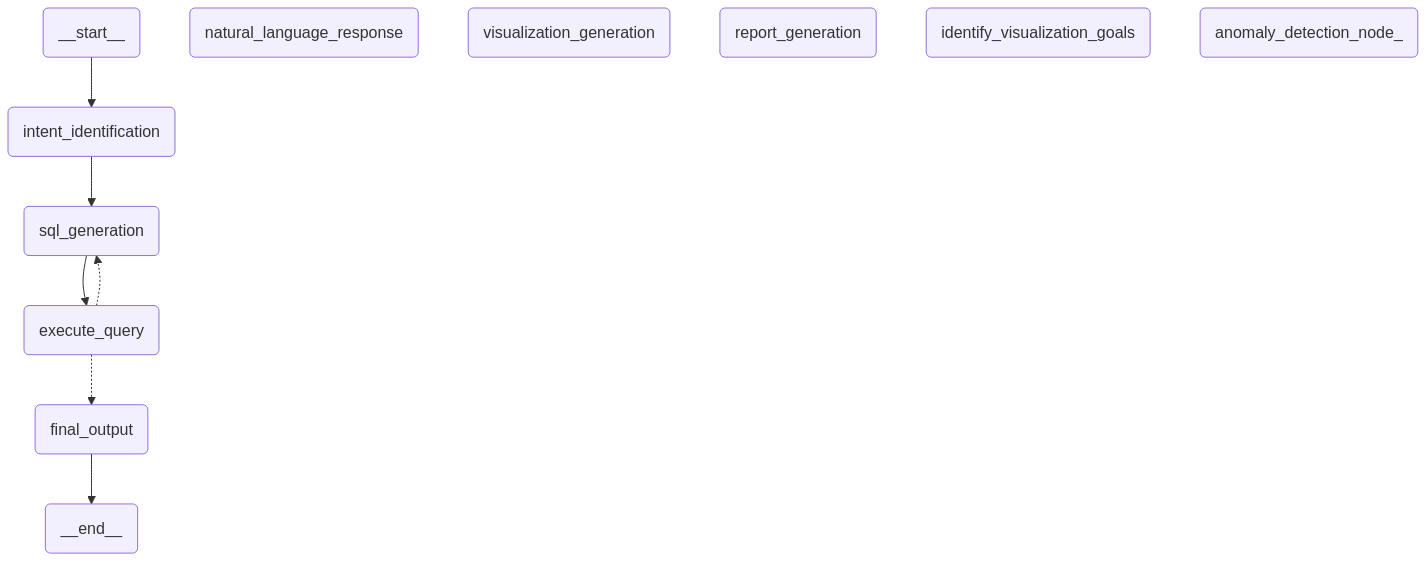

In [6]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

# Visualize the StateGraph
display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)


In [7]:
final_state = app.invoke({"user_query": "Any anomalies in daily report for March 2024 showing Date and Daily Census for Queens ?"})
# Pretty-print the SQL query or queries used:
print("==== SQL Query/Queries Used ====")
sql_queries = final_state.get("sql_queries", [])
if sql_queries:
    for idx, query in enumerate(sql_queries):
        print(f"\nQuery {idx+1}:")
        print(query)
else:
    print("No SQL queries found.")

# Pretty-print the final natural language response:
print("\n==== Final NL Response ====")
response = final_state.get("nl_response", "No response found.")
print(response)

["SELECT d.CensusDateDate AS Date, COUNT(f.CensusId) AS DailyCensus\nFROM Fact_Census f\nJOIN Dim_CensusDate d ON f.CensusDateKey = d.CensusDateKey\nJOIN Dim_CensusLocation l ON f.LocationKey = l.LocationKey\nWHERE d.CensusDateYear = 2024\nAND d.CensusDateMonth = 3\nAND l.LocationName = 'Queens'\nGROUP BY d.CensusDateDate;"]
---FINAL OUTPUT NODE---
---ANOMALY DETECTION NODE---
==== SQL Query/Queries Used ====

Query 1:
SELECT d.CensusDateDate AS Date, COUNT(f.CensusId) AS DailyCensus
FROM Fact_Census f
JOIN Dim_CensusDate d ON f.CensusDateKey = d.CensusDateKey
JOIN Dim_CensusLocation l ON f.LocationKey = l.LocationKey
WHERE d.CensusDateYear = 2024
AND d.CensusDateMonth = 3
AND l.LocationName = 'Queens'
GROUP BY d.CensusDateDate;

==== Final NL Response ====
No response found.


In [32]:
if __name__ == "__main__":
    # Example usage
    user_query_example = "Can you identify any anomalies in the Daily Census in Travis for March 2024 ?"
    intent_result = identify_intent(user_query_example)
    print("Intent Result:", intent_result)

Intent Result: intent='Anomaly detection in Daily Census for Travis in March 2024' confidence=0.9 report=False visualize=False visual_instructions='' anomaly=True


In [20]:
! py -m pip freeze

absl-py==1.0.0
aiohttp==3.9.5
aiosignal==1.3.1
altair==5.3.0
annotated-types==0.6.0
anyio==3.5.0
argon2-cffi==21.3.0
argon2-cffi-bindings==21.2.0
asgiref==3.8.1
asttokens==2.0.5
astunparse==1.6.3
async-timeout==4.0.3
asyncio==3.4.3
attrs==21.4.0
Babel==2.9.1
backcall==0.2.0
backoff==2.2.1
bcrypt==4.1.3
beautifulsoup4==4.12.3
black==21.12b0
bleach==4.1.0
blinker==1.7.0
blis==1.0.1
boto3==1.34.112
botocore==1.34.112
bs4==0.0.2
build==1.2.1
cachetools==5.0.0
catalogue==2.0.10
certifi==2024.2.2
cffi==1.15.0
chardet==5.2.0
charset-normalizer==3.3.2
chroma-hnswlib==0.7.3
chromadb==0.5.0
click==8.1.7
cloudpathlib==0.20.0
cloudpickle==2.0.0
cohere==5.5.3
colorama==0.4.6
coloredlogs==15.0.1
comm==0.2.2
comtypes==1.4.5
confection==0.1.5
contourpy==1.3.0
cryptography==43.0.1
cycler==0.11.0
cymem==2.0.10
dataclasses-json==0.6.4
datasets==2.19.1
debugpy==1.5.1
decorator==5.1.1
deepdiff==7.0.1
defusedxml==0.7.1
Deprecated==1.2.14
dill==0.3.8
dirtyjson==1.0.8
diskcache==5.6.3
distro==1.9.0
Django==5.